# 파이토치가 자동으로 미분을 계산하는 방법

[Pytorch](https://pytorch.org/)는 Tensorflow와 같이 유명한 딥러닝 라이브러리입니다

파이토치의 핵심 기능은 자동 미분입니다.   
작고 소중한 버전으로 파이토치를 직접 만들어봅시다. 

`pip install matplotlib graphviz torch`

# 첫 Value 클래스 만들기

In [23]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data

        self._prev = set(_children)
        self._op = _op
        self.label = label

        self.grad=0

    def __repr__(self) -> str:
        return f'Value({self.data})'
    
    def __add__(self, other):
        return Value(self.data+other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [24]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

a, b, c

(Value(2.0), Value(-3.0), Value(10.0))

In [25]:
a*b

Value(-6.0)

In [26]:
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(-8.0)

In [27]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

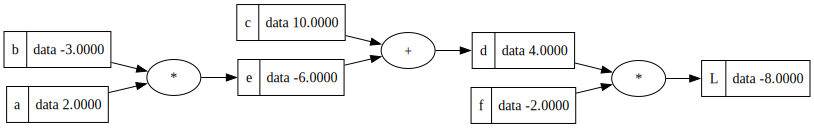

In [28]:
draw_dot(L)

# 손수 역전파

$L=d\times f$   

$\frac{dL}{dd}=f=-2$
   
$\frac{dL}{df}=d=4$

In [29]:
L.grad = 1
d.grad = -2
f.grad = 4

$d=c+e$   

$\frac{dL}{de}=\frac{dL}{dd}\cdot \frac{dd}{de} =-2\times 1$   

$\frac{dL}{dc}=\frac{dL}{dd}\cdot \frac{dd}{dc} =-2\times 1$

In [30]:
e.grad = -2 * 1
c.grad = -2 * 1

$e=a\times b$   

$\frac{dL}{da}=\frac{dL}{dd}\cdot \frac{dd}{de}\cdot \frac{de}{da} =-2\times 1 \times -3$   

$\frac{dL}{db}=\frac{dL}{dd}\cdot \frac{dd}{de}\cdot \frac{de}{db} =-2\times 1 \times 2$

In [31]:
a.grad = -2 * 1 * -3
b.grad = -2 * 1 * 2

In [32]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

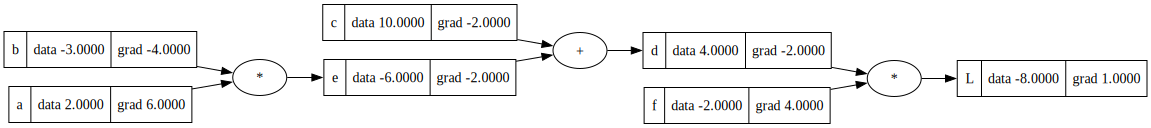

In [33]:
draw_dot(L)

In [34]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [35]:
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


# 인공 뉴런(퍼셉트론) 만들기

In [43]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data

        self._prev = set(_children)
        self._op = _op
        self.label = label

        self.grad=0

    def __repr__(self) -> str:
        return f'Value({self.data})'
    
    def __add__(self, other):
        return Value(self.data+other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        return Value(t, (self,), 'tanh')

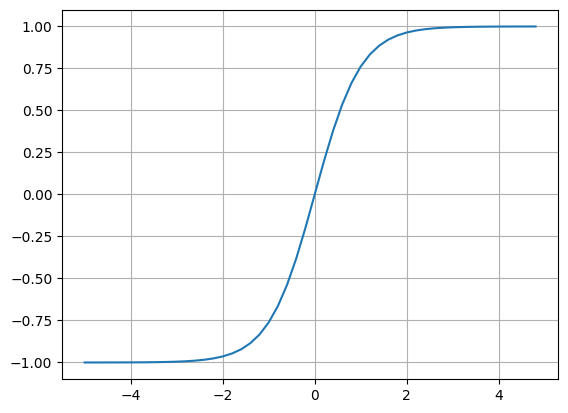

In [44]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [45]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

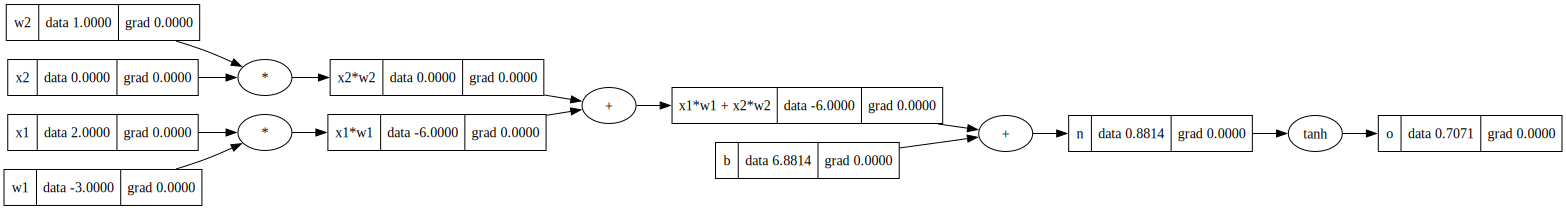

In [46]:
draw_dot(o)

In [47]:
1 - o.data**2

0.4999999999999999

In [ ]:
o.grad = 1
n.grad = 0.5             # 1 - o.data**2

b.grad = 0.5 * 1
x1w1x2w2.grad = 0.5 * 1

x2w2.grad = 0.5 * 1 * 1
x1w1.grad = 0.5 * 1 * 1

w2.grad = 0.5 * 1 * 1 * x2.data
x2.grad = 0.5 * 1 * 1 * w2.data

w1.grad = 0.5 * 1 * 1 * x1.data
x1.grad = 0.5 * 1 * 1 * w1.data

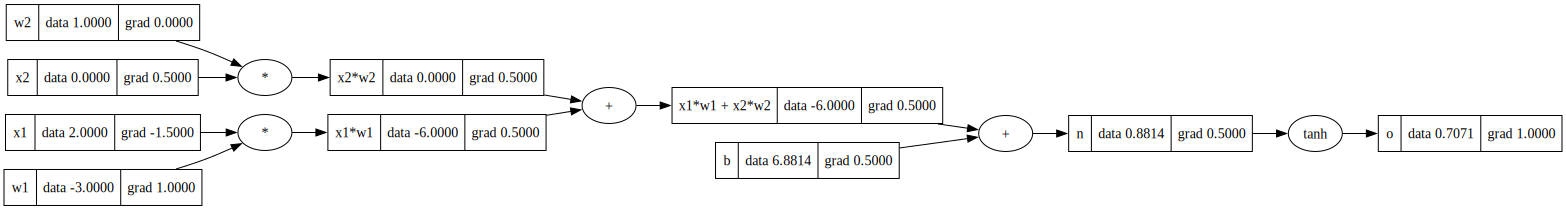

In [49]:
draw_dot(o)

# `_backward()` 메서드 만들기

In [50]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value({self.data}, label={self.label})'
    
    def __add__(self, other):
        out = Value(self.data+other.data, (self, other), '+')
		    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
		   
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
		    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        return out

`_children` Value들의 grad 업데이트할 수 있음

In [60]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [61]:
o.grad = 1
o._backward()

In [62]:
n.grad

0.4999999999999999

In [63]:
n._backward()
x1w1x2w2.grad, b.grad

(0.4999999999999999, 0.4999999999999999)

In [64]:
x1w1x2w2._backward()
x1w1.grad, x2w2.grad

(0.4999999999999999, 0.4999999999999999)

In [65]:
x2w2._backward()
x2.grad, w2.grad

(0.4999999999999999, 0.0)

In [66]:
x1w1._backward()
x1.grad, w1.grad

(-1.4999999999999996, 0.9999999999999998)

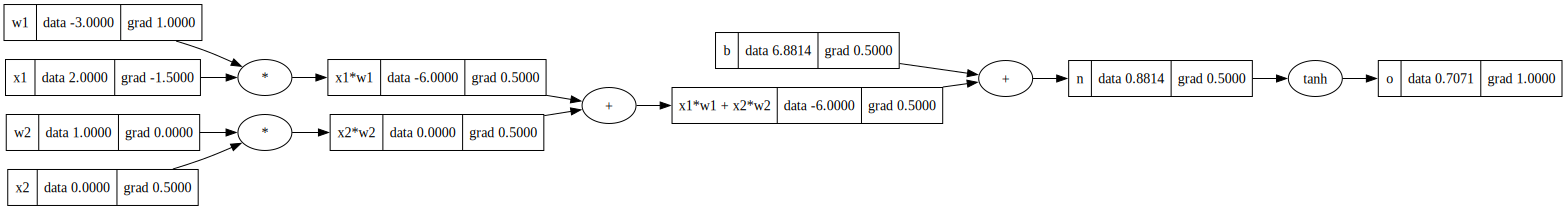

In [67]:
draw_dot(o)

# 자동 backward 만들기

모든 Value 노드마다 `_backward()`를 실행하는건 귀찮죠?   
마지막 노드(o)에서 한번만 backward 하도록 만들어봅시다!

## topological sort

In [73]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

In [74]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [75]:
build_topo(o)
topo

[Value(2.0, label=x1),
 Value(-3.0, label=w1),
 Value(-6.0, label=x1*w1),
 Value(1.0, label=w2),
 Value(0.0, label=x2),
 Value(0.0, label=x2*w2),
 Value(-6.0, label=x1*w1 + x2*w2),
 Value(6.881373587019543, label=b),
 Value(0.8813735870195432, label=n),
 Value(0.7071067811865476, label=o)]

In [76]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

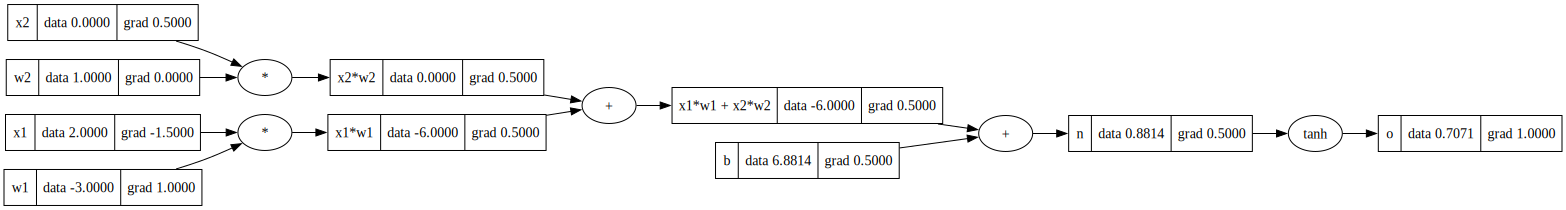

In [77]:
draw_dot(o)

In [78]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value({self.data}, label={self.label})'
    
    def __add__(self, other):
        out = Value(self.data+other.data, (self, other), '+')
		    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
		   
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
		    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [79]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [80]:
o.backward()

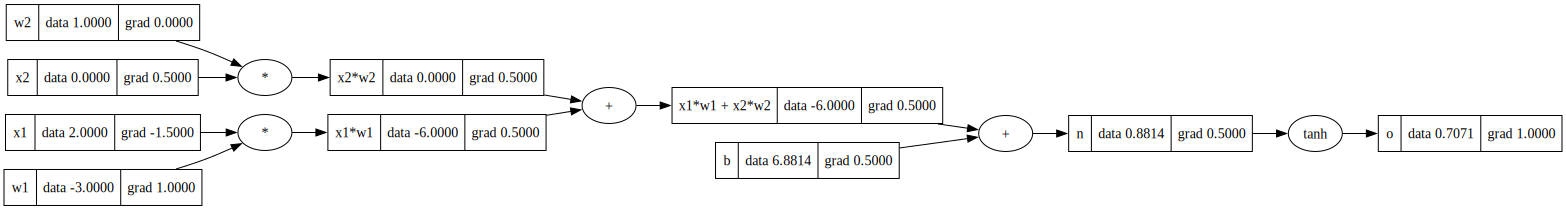

In [81]:
draw_dot(o)

# tanh 연산 쪼개기

tanh 연산을 더 작게 쪼개봅시다
- exponential
    - 그냥 exp 메서드
- division
    - `__pow__` 연산자 오버로딩 → `노드**(-1)`로 역수 취하고 `__mul__`
- subtraction
    - `__neg__` 연산자 오버로딩 → `(-노드)`하고 `__add__`

In [82]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value({self.data}, label={self.label})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), '+')
		    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
		   
        return out
    
    def __radd__(self, other):
        return self+other

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
		    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        x = self.data
        out = Value(x**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other*(x**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * (other**(-1))

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


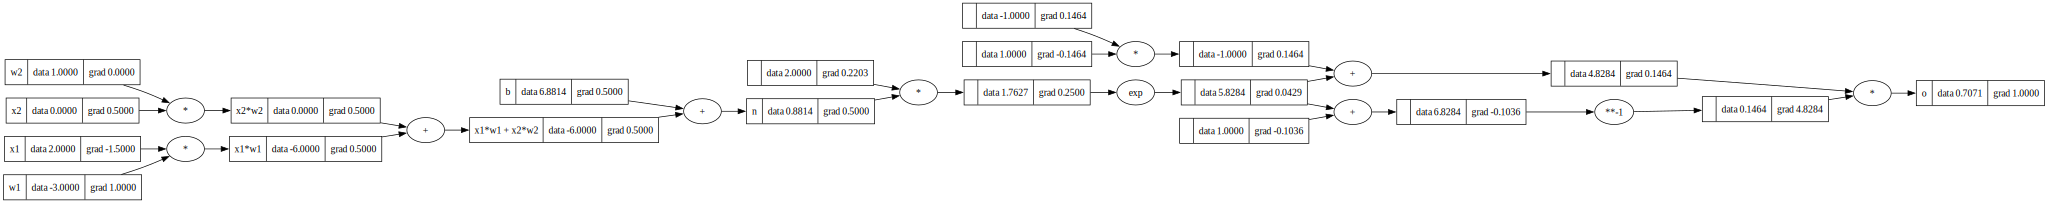

In [85]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

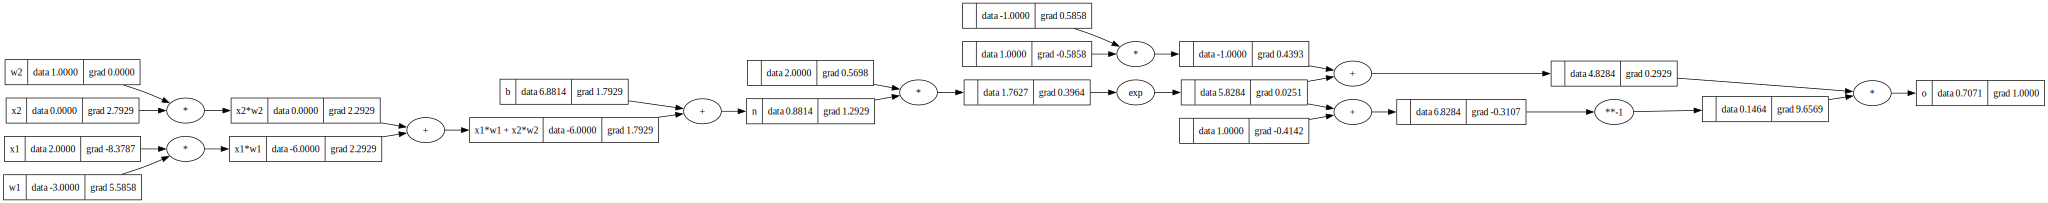

In [86]:
o.backward()
draw_dot(o)

# 파이토치로 해보기

In [90]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# 신경망 라이브러리 만들기
## 뉴런 만들기

In [87]:
import random

class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x: list):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [88]:
n = Neuron(3)
n([2.0, 3.0, 1.0])

Value(0.22165408116278967, label=)

## 레이어, MLP 만들기

In [98]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:

    def __init__(self, nin, nouts):
        size = [nin] + nouts

        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):

        for layer in self.layers:
            x = layer(x)
        return x

In [99]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(-0.8847532636783466, label=)

In [100]:
n.layers[0].neurons[0].w[0].grad

0

## 작은 데이터 셋으로 loss 구하기

In [101]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [102]:
ypreds = [n(xi) for xi in xs]
ypreds

[Value(-0.8847532636783466, label=),
 Value(-0.8658191845801624, label=),
 Value(-0.879248049722022, label=),
 Value(-0.8339578744988229, label=)]

In [103]:
# Mean Squared Error(MSE)
loss = sum((((ypred - y)**2 for ypred, y in zip(ypreds, ys))))
loss

Value(6.948281875105087, label=)

In [104]:
loss.backward()

In [105]:
n.layers[0].neurons[0].w[0].grad

-0.022403162042443664

## `parameters()` 만들기

모든 파라미터 모으는 메서드 

In [106]:
class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        size = [nin] + nouts

        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):

        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [107]:
n = MLP(3, [4,4,1])
len(n.parameters())

41

In [108]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [109]:
ypreds = [n(xi) for xi in xs]
ypreds

[Value(-0.7426935508515281, label=),
 Value(0.31169656545978025, label=),
 Value(-0.7389135290522663, label=),
 Value(-0.5670385047296767, label=)]

In [110]:
# Mean Squared Error(MSE)
loss = sum((((ypred - y)**2 for ypred, y in zip(ypreds, ys))))
loss

Value(7.281304512635854, label=)

In [111]:
loss.backward()

In [112]:
for p in n.parameters():
    p.data += -0.05 * p.grad # negative sign -> gradient descent, lr=0.05

In [114]:
ypreds = [n(xi) for xi in xs]
loss = sum((((ypred - y)**2 for ypred, y in zip(ypreds, ys))))
loss

Value(4.866376722765455, label=)

In [115]:
for epoch in range(10):
    ypreds = [n(xi) for xi in xs]

    loss = sum((((ypred - y)**2 for ypred, y in zip(ypreds, ys))))

    loss.backward()

    print(f'{epoch} epoch | loss:', loss)
    for p in n.parameters():
        p.data += -0.05 * p.grad

    for p in n.parameters():
        p.grad = 0

0 epoch | loss: Value(4.866376722765455, label=)
1 epoch | loss: Value(3.383914216515237, label=)
2 epoch | loss: Value(2.588964776220794, label=)
3 epoch | loss: Value(2.0480054785706647, label=)
4 epoch | loss: Value(1.537004533303167, label=)
5 epoch | loss: Value(1.1058910031418212, label=)
6 epoch | loss: Value(0.7847463412286224, label=)
7 epoch | loss: Value(0.5650079892382596, label=)
8 epoch | loss: Value(0.4192840391768284, label=)
9 epoch | loss: Value(0.32186505496290185, label=)


# 참고

https://github.com/karpathy/micrograd/blob/master/demo.ipynb


https://www.youtube.com/watch?v=VMj-3S1tku0